# Support Ticket Classification & Prioritization
Machine Learning Task 2 – Future Interns (2026)

Dataset Used:
Customer Support Ticket Dataset (Kaggle)

Objective:
- Classify support tickets into categories
- Predict ticket priority (High / Medium / Low)
- Build a decision-support system for businesses


## Business Problem

Customer support teams receive large volumes of tickets daily.
Manual sorting leads to:

- Delayed urgent responses
- Misrouted tickets
- Increased operational workload

This project builds an NLP-based ML system to:
- Automatically categorize tickets
- Predict urgency level
- Improve response efficiency


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [28]:
df = pd.read_csv("customer_support_tickets.csv")
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [29]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [30]:
df.columns

Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating'],
      dtype='object')

# Handle Missing Values

If ticket text is missing → model cannot learn . 
If category is missing → no label to train

In [31]:
df.isnull().sum()


Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64

In [32]:
df = df.drop(columns=[
    'Resolution',
    'First Response Time',
    'Time to Resolution',
    'Customer Satisfaction Rating'
])


## Handling Missing Values

Some columns contained a large number of missing values:
- Resolution
- First Response Time
- Time to Resolution
- Customer Satisfaction Rating

Since these columns are not required for ticket classification
or priority prediction, they were removed to maintain data quality.

The remaining dataset contains no missing values
and is ready for preprocessing.


In [33]:
df.isnull().sum()


Ticket ID             0
Customer Name         0
Customer Email        0
Customer Age          0
Customer Gender       0
Product Purchased     0
Date of Purchase      0
Ticket Type           0
Ticket Subject        0
Ticket Description    0
Ticket Status         0
Ticket Priority       0
Ticket Channel        0
dtype: int64

## Exploratory Data Analysis (EDA)
EDA helps us understand:

Class distribution

Imbalance

Business insights

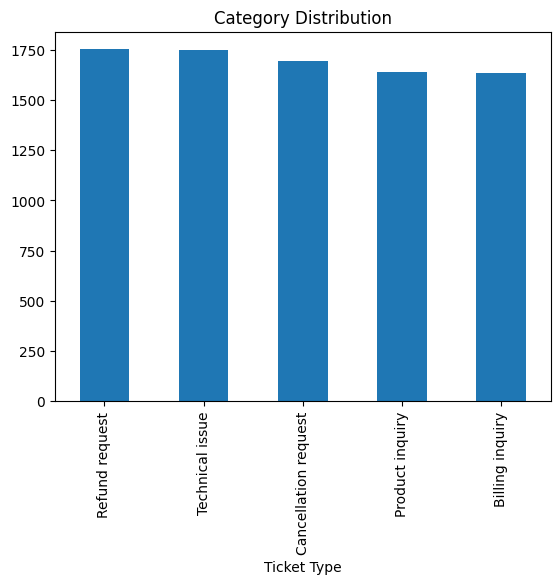

In [34]:
df['Ticket Type'].value_counts().plot(kind='bar')
plt.title("Category Distribution")
plt.show()


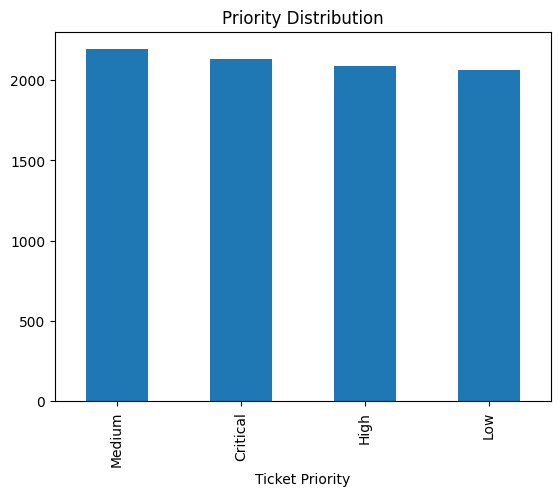

In [35]:
df['Ticket Priority'].value_counts().plot(kind='bar')
plt.title("Priority Distribution")
plt.show()


## Text Preprocessing (Core NLP Step)
Text contains:

Uppercase letters . 
Punctuation . 
Stopwords (is, the, and, etc.) . 
Noise . 

We clean it to improve model accuracy.

In [37]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['Ticket Description'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Convert Text to Numbers (TF-IDF)


In [38]:
vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(df['clean_text'])
y_category = df['Ticket Type']
y_priority = df['Ticket Priority']


# Train-Test Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_category, test_size=0.2, random_state=42
)


# Train Model (Logistic Regression)

Logistic Regression is good for:

Classification

Text problems

Multi-class prediction

In [40]:
model_category = LogisticRegression(max_iter=1000)
model_category.fit(X_train, y_train)

y_pred_category = model_category.predict(X_test)


# Model Evaluation

We use:

Accuracy → Overall correctness

Precision → Correct positive predictions

Recall → How well we detect actual positives

Confusion Matrix → Visual error analysis

In [41]:
print("Accuracy:", accuracy_score(y_test, y_pred_category))
print(classification_report(y_test, y_pred_category))


Accuracy: 0.19834710743801653
                      precision    recall  f1-score   support

     Billing inquiry       0.19      0.14      0.16       357
Cancellation request       0.18      0.20      0.19       327
     Product inquiry       0.19      0.18      0.18       316
      Refund request       0.21      0.24      0.22       345
     Technical issue       0.22      0.24      0.23       349

            accuracy                           0.20      1694
           macro avg       0.20      0.20      0.20      1694
        weighted avg       0.20      0.20      0.20      1694



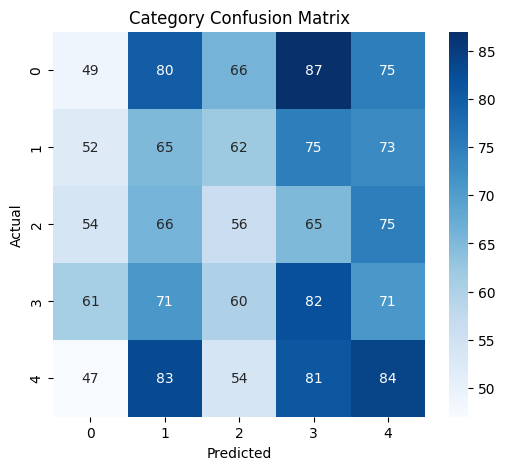

In [44]:
cm = confusion_matrix(y_test, y_pred_category)

plt.figure(figsize=(6,5))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues')   # Light blue theme

plt.title("Category Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [45]:
# repeat same process
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X, y_priority, test_size=0.2, random_state=42
)

model_priority = LogisticRegression(max_iter=1000)
model_priority.fit(X_train_p, y_train_p)

y_pred_priority = model_priority.predict(X_test_p)

print("Priority Accuracy:", accuracy_score(y_test_p, y_pred_priority))
print(classification_report(y_test_p, y_pred_priority))


Priority Accuracy: 0.26092089728453366
              precision    recall  f1-score   support

    Critical       0.25      0.26      0.25       411
        High       0.27      0.28      0.28       409
         Low       0.24      0.23      0.24       415
      Medium       0.28      0.27      0.28       459

    accuracy                           0.26      1694
   macro avg       0.26      0.26      0.26      1694
weighted avg       0.26      0.26      0.26      1694



## Business Impact

This system:

- Automatically routes tickets
- Identifies urgent complaints
- Reduces manual sorting workload
- Improves response time
- Enhances customer satisfaction

It can be integrated into:
- SaaS platforms
- IT support systems
- CRM dashboards


## Conclusion

We built an NLP-based classification system that:

- Cleans and processes raw text
- Converts text to numerical features
- Classifies ticket category
- Predicts ticket priority

This demonstrates a real-world operational ML application.
